In [1]:
using LinearAlgebra
import Plots as plt

include("../lib/test_functions.jl")
import .TestFunctions: ackley

In [2]:
using Distributions
using Random

function logarithmic_annealing_schedule(t0::Number)
    return (k::Int64) -> t0 * log(2) / log(k + 1)
end

function exponential_annealing_schedule(t0::Number, γ::Float64=0.85)
    tk = t0
    return (k::Int64 = 0) -> tk *= γ
end

function fast_annealing_schedule(t0::Number)
    return (k::Int64) -> t0 / k
end

function simple_simulated_annealing(
    f::Function,
    x0::Vector{Float64},
    transition_distribution::ContinuousUnivariateDistribution,
    temperature_schedule::Function;
    max_iter::Int64=20,
    max_traces=1e3
)
    x, y = x0, f(x0)
    x_best, y_best = x, y
    dim = length(x0)
    traces = []
    trace_step_size = ceil(max_iter / max_traces)
    push!(traces, x)
    for iter in 1:max_iter
        x_next = x + rand(transition_distribution, dim)
        y_next = f(x_next)
        Δy = y_next - y
        if Δy <= 0 || rand() < exp(-Δy / temperature_schedule(iter))
            x, y = x_next, y_next
        end
        if y_next < y_best
            x_best, y_best = x_next, y_next
        end
        if iter % trace_step_size == 0
            push!(traces, x_next)
        end
    end
    push!(traces, x_best)
    return x_best, y_best, traces, max_iter
end

simple_simulated_annealing (generic function with 1 method)

In [3]:
using DataStructures

function basis(i, n)
    vec = zeros(n)
    vec[i] = 1
    return vec
end

function corana_update(v, a, c, ns)
    new_v = copy(v)
    for i in 1:length(v)
        ai, ci = a[i], c[i]
        if ai > 0.6ns
            new_v[i] *= (1 + ci * (ai / ns - 0.6) / 0.4)
        elseif ai < 0.4ns
            new_v[i] /= (1 + ci * (0.4 - ai / ns) / 0.4)
        end
    end
    new_a = zeros(length(a))
    return new_v, new_a
end

function adaptive_simulated_annealing(
    f::Function,
    x0::Vector{Float64},
    v::Vector{Float64},
    temperature::Float64;
    γ=0.85,
    ns=20,
    nt=max(100, 5 * length(x0)),
    c=fill(2, length(x0)),
    # Termination conditions
    ϵ=1e-3,
    nϵ=4,
    trace_step_size=50
)
    x, y = x0, f(x0)
    x_best, y_best = x, y
    y_arr, dim = CircularBuffer{Number}(nϵ), length(x0)
    a, count_cycles, count_resets, iter = zeros(dim), 0, 0, 0

    traces = []
    push!(traces, x)

    while true
        for i in 1:dim
            x_next = x + basis(i, dim) * rand(Uniform(-1.0, 1.0)) * v[i]
            y_next = f(x_next)
            Δy = y_next - y
            if Δy <= 0 || rand() < exp(-Δy / temperature)
                x, y = x_next, y_next
                a[i] += 1
                if y_next < y_best
                    x_best, y_best = x_next, y_next
                end
            end
            iter += 1
            if iter % trace_step_size == 0
                push!(traces, x_next)
            end
        end

        count_cycles += 1
        count_cycles < ns && continue
        count_cycles = 0

        v, a = corana_update(v, a, c, ns)
        count_resets += 1
        count_resets < nt && continue
        count_resets = 0

        temperature *= γ
        push!(y_arr, y)

        if !(
            isfull(y_arr)
            && y_arr[end] - y_best <= ϵ
            && all(abs.(y_arr .- y_arr[end]) .<= ϵ)
        )
            x, y = x_best, y_best
        else
            break
        end
    end
    push!(traces, x_best)
    return x_best, y_best, traces, iter
end

adaptive_simulated_annealing (generic function with 1 method)

"Simple simulated annealing - Optimum: x=[0.0, 0.0001]; f=0.0002 in 100000 iterations"

"Adaptive simulated annealing - Optimum: x=[0.0, 0.0]; f=0.0 in 92000 iterations"

"Adaptive simulated annealing - Sample size = 1841/1842 (filtered/total)"

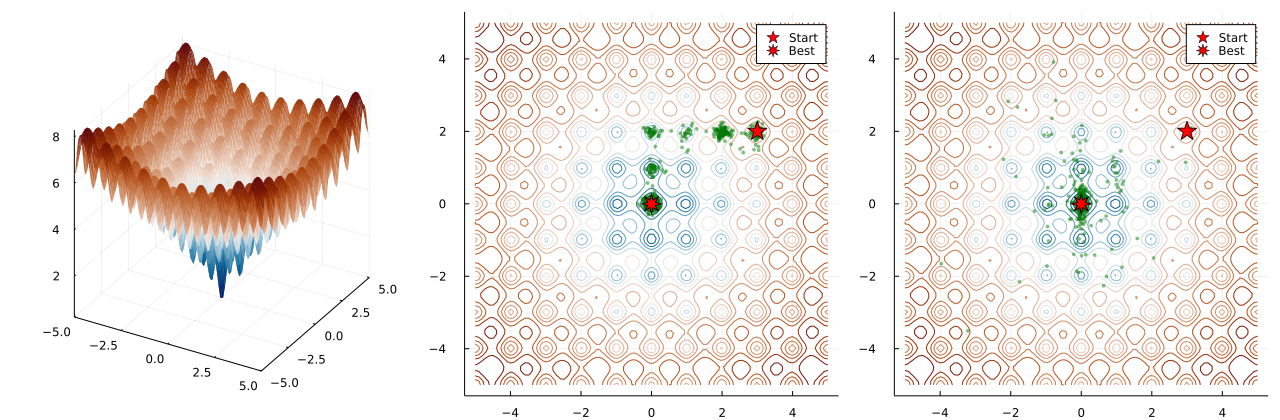

In [4]:
f = ackley(10.0)
x0 = [3.0, 2.0]

xdomain = LinRange(-5, 5, 100)
ydomain = LinRange(-5, 5, 100)

function plot_process(x0::Vector{Float64}, x::Vector{Float64}, traces::Vector)
    plot = plt.contour(xdomain, ydomain, (x, y) -> f([x, y]); color=plt.cgrad(:vik), colorbar=false, size=(420, 420))
    plt.scatter!(plot, [p[1] for p in traces], [p[2] for p in traces]; markersize=2, markeralpha=0.5, markerstrokewidth=0, markercolor=:green, label="")
    plt.scatter!(plot, [x0[1]], [x0[2]]; markershape=:star1, markersize=10, markerstrokewidth=1, markercolor=:red, label="Start")
    plt.scatter!(plot, [x[1]], [x[2]]; markershape=:star2, markersize=10, markerstrokewidth=1, markercolor=:red, label="Best")
    return plot
end

function run_simple_sa()
    Random.seed!(2)

    annealing_schedule = logarithmic_annealing_schedule(5.0)
    # annealing_schedule = exponential_annealing_schedule(1e5, 0.9999)
    # annealing_schedule = fast_annealing_schedule(5e4)

    # transition_distribution = Uniform(-2e-2, 2e-2)
    transition_distribution = Normal(0, 2e-2)

    x, y, traces, iterations = simple_simulated_annealing(
        f,
        x0,
        transition_distribution,
        annealing_schedule,
        max_iter=Int64(1e5),
        max_traces=1e3
    )
    display("Simple simulated annealing - Optimum: x=$(round.(x, digits=4)); f=$(round(y, digits=4)) in $iterations iterations")
    return plot_process(x0, x, traces)
end

function run_adaptive_sa()
    Random.seed!(2)

    x, y, traces, iterations = adaptive_simulated_annealing(
        f,
        x0,
        fill(2e-2, length(x0)),
        0.8;
        γ=0.85,
        ns=20,
        nt=50,
        c=fill(2, length(x0)),
        ϵ=1e-3,
        nϵ=4,
        trace_step_size=50,
    )
    display("Adaptive simulated annealing - Optimum: x=$(round.(x, digits=4)); f=$(round(y, digits=4)) in $iterations iterations")
    filtered_traces = [
        p
        for p in traces
        if -5 <= p[1] <= 5 && -5 <= p[2] <= 5
    ]
    display("Adaptive simulated annealing - Sample size = $(length(filtered_traces))/$(length(traces)) (filtered/total)")
    return plot_process(x0, x, filtered_traces)
end

plt.plot(
    plt.surface(xdomain, ydomain, (x, y) -> f([x, y]); opacity=0.9, colorbar=false, fill=(true, plt.cgrad(:vik))),
    run_simple_sa(),
    run_adaptive_sa(),
    layout=(1, 3),
    size=(1280, 420)
)